# Intro

[Sohoni et al.](https://arxiv.org/abs/1904.10631) combine techniques to reduce the memory consumption while training WideResNet. This project aims to reproduce their results using PyTorch's built-in library techniques to see whether their results are feasible.

**Contents**

1. [Models] Loading untrained models (WideResNet and Transformer) from the PyTorch library. I use PyTorch's library functions to add checkpoints and mixed precision to the model.

1. [Profile] The GPU memory profiler (third party tool) and plotting functions.

1. [Training] I write the training sling. This includes all of the ways to turn on memory-saving training techniques: Pruning, Quantisation and Checkpointing.

1. [GPU Experiments *] I run training with different combinations of memory-saving techniques.

1. [Evaluation] I graph the results.

**Which memory-saving techniques do I use?**

* Pruning: PyTorch provides the ability to apply a filter to the model's parameters to set certain parameters to zero.

* Mixed precision: PyTorch implements NVIDIA's [automatic mixed precision](https://developer.nvidia.com/blog/mixed-precision-training-deep-neural-networks/) (AMP) which mixes FP16 & FP32 and claims to match the accuracy of FP32 training. This now seems to be the dominant form of quantisation used in PyTorch.

* Quantisation: PyTorch also enables training in FP16

* Checkpointing: PyTorch implements standard checkpoint, where a function is re-computed on the backward pass. However it does not implement recursive checkpoint, such as RES-2* in the Sohoni paper.

* Micro-batching: PyTorch does not implement MicroBatching, probably because it makes everything very slow. Instead I simulate it using minibatches, which have the same memory properties.

In [2]:
import torch

import torchvision
import torchvision.transforms as transforms
import torchvision.models.resnet as resnet

import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.utils.prune as prune
import torch.autograd as autograd
import torch.utils.checkpoint as checkpoint
import torch.autograd.profiler as profiler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import OrderedDict
from typing import Optional

import pickle
import time

# Models

## WideResNet-50-2

In [ ]:
# Copied from: https://discuss.pytorch.org/t/replacing-convs-modules-with-custom-convs-then-notimplementederror/17736/3
def replace_relu(m, name):
    for attr_str in dir(m):
        target_attr = getattr(m, attr_str)
        if type(target_attr) == nn.ReLU:
            # print('replaced: ', name, attr_str)
            setattr(m, attr_str, nn.ReLU())
    for n, ch in m.named_children():
        replace_relu(ch, n)

In [ ]:
class WideResNet(resnet.ResNet):
    def __init__(self, mp=False, chk=0):
        super().__init__(resnet.Bottleneck, [3, 4, 6, 3], **{'width_per_group': 64 * 2})
        replace_relu(self, "WideResNet")
        self.mp = mp
        self.chk = chk

    def custom(self, module):
        def custom_forward(*inputs):
            with amp.autocast(enabled=self.mp):
                inputs = module(inputs[0])
            return inputs
        return custom_forward

    def forward(self, x):
        with amp.autocast(enabled=self.mp):
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.maxpool(x)

            if self.chk == 1:
                x = checkpoint.checkpoint(self.custom(self.layer1), x)
                x = checkpoint.checkpoint(self.custom(self.layer2), x)
                x = checkpoint.checkpoint(self.custom(self.layer3), x)
                x = checkpoint.checkpoint(self.custom(self.layer4), x)
            elif self.chk == 2:
                for layer in (self.layer1, self.layer2, self.layer3, self.layer4):
                    for block in layer:
                        x = checkpoint.checkpoint(self.custom(block), x)
            else:
                x = self.layer1(x)
                x = self.layer2(x)
                x = self.layer3(x)
                x = self.layer4(x)

            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)

        return x

## Transformer

In [ ]:
class TransformerEncoderCheckpoint(nn.TransformerEncoder):
    def __init__(self, encoder_layer, num_layers, norm=None, mp=False):
        super(TransformerEncoderCheckpoint, self).__init__(encoder_layer, num_layers, norm)
        self.mp=mp
      
    def custom(self, module):
        def custom_forward(*inputs):
            with amp.autocast(enabled=self.mp):
                inputs = module(inputs[0])
            return inputs
        return custom_forward

    def forward(self, src: torch.Tensor, mask: Optional[torch.Tensor] = None, 
                src_key_padding_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        with amp.autocast(enabled=self.mp):
            output = src

            for mod in self.layers:
                output = checkpoint.checkpoint(self.custom(mod), output)

            if self.norm is not None:
                output = self.norm(output)

        return output

class TransformerDecoderCheckpoint(nn.TransformerDecoder):
    def __init__(self, decoder_layer, num_layers, norm=None, mp=False):
        super(TransformerDecoderCheckpoint, self).__init__(decoder_layer, num_layers, norm)
        self.mp=mp
      
    def custom(self, module):
        def custom_forward(*inputs):
            with amp.autocast(enabled=self.mp):
                inputs = module(inputs[0], inputs[1])
            return inputs
        return custom_forward

    def forward(self, tgt: torch.Tensor, memory: torch.Tensor, tgt_mask: Optional[torch.Tensor] = None, 
                memory_mask: Optional[torch.Tensor] = None, tgt_key_padding_mask: Optional[torch.Tensor] = None,
                memory_key_padding_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        with amp.autocast(enabled=self.mp):
          output = tgt

          for mod in self.layers:
              output = checkpoint.checkpoint(self.custom(mod), *(output, memory))

          if self.norm is not None:
              output = self.norm(output)

        return output

class Transformer(nn.Transformer):
    def __init__(self, d_model: int = 512, nhead: int = 8, num_encoder_layers: int = 6,
                 num_decoder_layers: int = 6, dim_feedforward: int = 2048, dropout: float = 0.1,
                 activation: str = "relu", mp=False, chk=False) -> None:
        if chk:
            encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, activation)
            encoder_norm = nn.LayerNorm(d_model)
            checkpoint_encoder = TransformerEncoderCheckpoint(encoder_layer, num_encoder_layers, encoder_norm, mp)

            decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout, activation)
            decoder_norm = nn.LayerNorm(d_model)
            checkpoint_decoder = TransformerDecoderCheckpoint(decoder_layer, num_decoder_layers, decoder_norm, mp)
            super(Transformer, self).__init__(d_model, nhead, num_encoder_layers, num_decoder_layers,
                                              dim_feedforward, dropout, activation, 
                                              checkpoint_encoder, checkpoint_decoder)
        else:
            super(Transformer, self).__init__(d_model, nhead, num_encoder_layers, num_decoder_layers,
                                              dim_feedforward, dropout, activation)
        self.mp=mp
            
    def forward(self, src: torch.Tensor, tgt: torch.Tensor, src_mask: Optional[torch.Tensor] = None, tgt_mask: Optional[torch.Tensor] = None, memory_mask: Optional[torch.Tensor] = None, src_key_padding_mask: Optional[torch.Tensor] = None, tgt_key_padding_mask: Optional[torch.Tensor] = None, memory_key_padding_mask: Optional[torch.Tensor] = None):
        with amp.autocast(enabled=self.mp):
            return super().forward(src, tgt, src_mask, tgt_mask, memory_mask, src_key_padding_mask, tgt_key_padding_mask, memory_key_padding_mask)

# Profiler

Copied from https://github.com/quentinf00/article-memory-log

In [ ]:
# Code copied from https://github.com/quentinf00/article-memory-log

def _get_gpu_mem(synchronize=True, empty_cache=True):
    ret = torch.cuda.memory_allocated(), torch.cuda.memory_cached(), torch.cuda.max_memory_allocated()
    torch.cuda.reset_max_memory_allocated()
    return ret


def _generate_mem_hook(handle_ref, mem, idx, hook_type, exp):
    def hook(self, *args):
        if len(mem) == 0 or mem[-1]["exp"] != exp:
            call_idx = 0
        else:
            call_idx = mem[-1]["call_idx"] + 1

        mem_all, mem_cached, max_mem_all = _get_gpu_mem()
        torch.cuda.synchronize()
        mem.append({
            'layer_idx': idx,
            'call_idx': call_idx,
            'layer_type': type(self).__name__,
            'exp': exp,
            'hook_type': hook_type,
            'mem_all': mem_all,
            'mem_cached': mem_cached,
            'max_mem_all': max_mem_all,
        })

    return hook


def _add_memory_hooks(idx, mod, mem_log, exp, hr):
    h = mod.register_forward_pre_hook(_generate_mem_hook(hr, mem_log, idx, 'pre', exp))
    hr.append(h)

    h = mod.register_forward_hook(_generate_mem_hook(hr, mem_log, idx, 'fwd', exp))
    hr.append(h)

    h = mod.register_backward_hook(_generate_mem_hook(hr, mem_log, idx, 'bwd', exp))
    hr.append(h)

def add_hooks_to_model(model, mem_log=None, exp=None):
    mem_log = mem_log or []
    exp = exp or f'exp_{len(mem_log)}'
    hr = []
    for idx, module in enumerate(model.modules()):
        _add_memory_hooks(idx, module, mem_log, exp, hr)
    return mem_log, hr

def remove_hooks_from_model(hr):
    [h.remove() for h in hr]

In [ ]:
# Copied from https://github.com/quentinf00/article-memory-log

def pp(df, exp):
    df_exp = df[df.exp == exp]
    df_pprint = (
        df_exp.assign(
            open_layer=lambda ddf: ddf.hook_type.map(
                lambda x: {"pre": 0, "fwd": 1, "bwd": 2}[x]).rolling(2).apply(lambda x: x[0] == 0 and x[1] == 0, raw=True)
        )
            .assign(
            close_layer=lambda ddf: ddf.hook_type.map(
                lambda x: {"pre": 0, "fwd": 1, "bwd": 2}[x]).rolling(2).apply(lambda x: x[0] == 1 and x[1] == 1, raw=True)
        )
            .assign(indent_level=lambda ddf: (ddf.open_layer.cumsum() - ddf.close_layer.cumsum()).fillna(0).map(int))
            .sort_values(by="call_idx")
            .assign(mem_diff=lambda ddf: ddf.mem_all.diff() // 2 ** 20)
    )
    pprint_lines = [
        f"{'    ' * row[1].indent_level}{row[1].layer_type} {row[1].hook_type}  {row[1].mem_diff or ''}"
        for row in df_pprint.iterrows()
    ]
    for x in pprint_lines:
        print(x)


def plot_mem(
        df,
        exps=None,
        normalize_call_idx=True,
        normalize_mem_all=True,
        filter_fwd=False,
        return_df=False,
        output_file=None,
        vlines=[],
        hlines=[],
        vadj=0
):
    if exps is None:
        exps = df.exp.drop_duplicates()

    fig, ax = plt.subplots(figsize=(20, 10))
    for exp in exps:
        df_ = df[df.exp == exp]

        if normalize_call_idx:
            df_.call_idx = df_.call_idx / df_.call_idx.max()

        if normalize_mem_all:
            df_.mem_all = df_.mem_all - df_[df_.call_idx == df_.call_idx.min()].mem_all.iloc[0]
            df_.mem_all = (df_.mem_all + vadj) // 2 ** 20
            # df_.max_mem_all = df_.max_mem_all - df_[df_.call_idx == df_.call_idx.min()].max_mem_all.iloc[0]
            # df_.max_mem_all = (df_.max_mem_all + vadj) // 2 ** 20

        if filter_fwd:
            layer_idx = 0
            callidx_stop = df_[(df_["layer_idx"] == layer_idx) & (df_["hook_type"] == "fwd")]["call_idx"].iloc[0]
            df_ = df_[df_["call_idx"] <= callidx_stop]
            # df_ = df_[df_.call_idx < df_[df_.layer_idx=='bwd'].call_idx.min()]

        ax = df_.plot(ax=ax, x='call_idx', y='mem_all', label=exp)
        # ax = df_.plot(ax=ax, x='call_idx', y='max_mem_all', label=exp)
      
        for (label, vline) in vlines:
            ax.axvline(vline, lw=1, ls="--")
            plt.text(vline + 0.1,0,label,rotation=90)
        for (label, hline) in hlines:
            hline = hline // 2 ** 20
            ax.axhline(hline, lw=1, alpha=0.5, ls="--")
            plt.text(0, hline + 0.1,label)
        if output_file:
            ax.get_figure().savefig(output_file)

    if return_df:
        return df_

In [ ]:
def get_model_param_mem(model):
    bits = 0
    for parameter in model.parameters():
        if parameter.dtype == torch.float32:
            bits += 32 * parameter.size().numel()
        elif parameter.dtype == torch.float16:
            bits += 16 * parameter.size().numel()
        else:
            raise NotImplementedError("get model mem: " + parameter.dtype)

    return bits

def record_gpu_mem(recorder, record_name, should_record):
    if should_record:
        gpu_mem = _get_gpu_mem()[0]
        torch.cuda.synchronize()
        recorder[record_name] = gpu_mem

def record_time(recorder, record_name, should_record):
    if should_record:
        torch.cuda.synchronize()
        recorder[record_name] = time.time()

In [ ]:
def plot_grad_mem(
        df,
        exps=None
):
    if exps is None:
        exps = df.exp.drop_duplicates()

    def get_grad_mem(exp):
        df_ = df[df.exp == exp]
        init_mem = df_[df_.call_idx == df_.call_idx.min()].mem_all.iloc[0]
        fin_mem = df_[df_.call_idx == df_.call_idx.max()].mem_all.iloc[0]
        return (fin_mem - init_mem) // 2 ** 20

    grad_mems = [get_grad_mem(exp) for exp in exps]

    fig, ax = plt.subplots()
    ax.bar(exps, grad_mems)

def plot_zerograd_mem(
        mems,
        exps=None
):
    if exps is None:
        exps = list(df.keys())

    def get_grad_mem(exp):
        init_mem = mems[exp]['post_input']
        fin_mem = mems[exp]['zero_grad']
        return (init_mem - fin_mem) // 2 ** 20

    grad_mems = [get_grad_mem(exp) for exp in exps]

    fig, ax = plt.subplots()
    ax.bar(exps, grad_mems)

def plot_input_mem(
        mems,
        exps=None
):
    if exps is None:
        exps = list(df.keys())

    def get_grad_mem(exp):
        init_mem = mems[exp]['pre_input']
        fin_mem = mems[exp]['post_input']
        return (fin_mem - init_mem) // 2 ** 20

    grad_mems = [get_grad_mem(exp) for exp in exps]

    fig, ax = plt.subplots()
    ax.bar(exps, grad_mems)

def plot_model_mem(
        mems,
        exps=None
):
    if exps is None:
        exps = list(df.keys())

    grad_mems = [mems[exp]['model'] // 2 ** 20 for exp in exps]

    fig, ax = plt.subplots()
    ax.bar(exps, grad_mems)

def plot_all_others(
    df,
    exps = None
):
    if exps is None:
        df_ = df
    else:
        df_ = df.loc[exps]
    ax = df_.plot.bar(figsize=(20,15))
    # return df_.head()

def plot_all_others_diffs(df, exps=None):
    if exps is None:
        df_ = df
    else:
        df_ = df.loc[exps]
    df_ = df_.diff(axis=1).drop(['init', 'warmup', 'input', 'enter'], axis=1)
    ax = df_.plot.bar(figsize=(20,15))
    # return df_.head()

# Training

In [ ]:
# This is my own work to create a training sling that can turn on low-memory techniques
def get_parameters_to_prune(model):
    to_prune = []
    def _inner(module):
        has_children = False
        for name, child in module.named_children():
            has_children = True
            _inner(child)
        if not has_children:
            to_prune.extend([(module, param) for param, _ in module.named_parameters()])
    _inner(model)
    return to_prune

def prune_smallest_remaining(parameters_to_prune, amount):
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount
    )

def remove_prune(parameters_to_prune):
    for module, name in parameters_to_prune:
        prune.remove(module, name)

def standard_loss(fwd, optimizer, criterion, inputs, labels, other_mems, should_record):
    # mem = weights + gradients
    record_gpu_mem(other_mems, "enter", should_record)
    optimizer.zero_grad(set_to_none=True)
    # mem = weights
    record_gpu_mem(other_mems, "zero", should_record)
    outputs = fwd(inputs, labels)
    # mem = weights + activations
    record_gpu_mem(other_mems, "fwd", should_record)
    loss = criterion(outputs, labels)
    loss.backward()
    # mem = weights + gradients
    record_gpu_mem(other_mems, "bwd", should_record)
    optimizer.step()
    # mem = weights + gradients
    record_gpu_mem(other_mems, "step", should_record)
    return loss

# uses nvidia mixed precision
def quantise_loss(fwd, optimizer, criterion, inputs, labels, other_mems, should_record, scaler):
    # mem = weights_32 + gradients_32
    record_gpu_mem(other_mems, "enter", should_record)
    optimizer.zero_grad(set_to_none=True)
    # mem = weights_32
    record_gpu_mem(other_mems, "zero", should_record)
    
    ## NOTE: amp context manager must now be implemented inside the model!
    outputs = fwd(inputs, labels)
    # mem = weights_32 + weights_16 + activations_16
    record_gpu_mem(other_mems, "fwd", should_record)
    loss = criterion(outputs, labels)

    scaler.scale(loss).backward()
    # mem = weights_32 + weights_16 + gradients_16
    record_gpu_mem(other_mems, "bwd", should_record)
    scaler.step(optimizer)
    # mem = weights_32 + gradients_32
    record_gpu_mem(other_mems, "step", should_record)
    scaler.update()
    return loss

def train(model, criterion, dataloader, fwd, exp=None, epochs=1, batches=-1,
          fp16="neither", mixed_precision=False, sparsity=0.0, segments=-1, 
          profile_epoch=-1, prof_batch=-1, mem_log_batch=-1, time_batch=-1, 
          print_stride=None):
    if mixed_precision: 
      scaler = amp.GradScaler()

    if sparsity > 0.0:
        running_sparsity = 0.0
        sparsity_increment = sparsity / (epochs-1) # will not prune after last iteration
        parameters_to_prune = get_parameters_to_prune(model)

    prof = None
    mem_log = []
    other_mems = {}

    print_stride = print_stride or 50

    # criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

    is_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if is_cuda else "cpu")

    if fp16 != "neither":
        model = model.to(torch.float16)

    # if mem_log_batch >= 0:
    #     model_mem = get_model_param_mem(model)
    model.train()

    # mem = 0
    record_gpu_mem(other_mems, "init", mem_log_batch >= 0)
    model.to(device)
    # mem = weights
    record_gpu_mem(other_mems, "model", mem_log_batch >= 0)

    for epoch in range(epochs):
        if sparsity > 0.0 and epoch > 0:
            running_sparsity += sparsity_increment
            prune_smallest_remaining(parameters_to_prune, running_sparsity)
            remove_prune(parameters_to_prune)

        running_loss = 0.0
        # for i, data in enumerate(trainloader, 0):
        for i in range(batches):
            # if batches > 0 and i == batches:
            #     break
            should_mem_log = mem_log_batch == i and profile_epoch == epoch
            should_prof = prof_batch == i and profile_epoch == epoch
            should_time = time_batch == i and profile_epoch == epoch

            # mem = ?
            record_gpu_mem(other_mems, "warmup", should_mem_log)

            # get the inputs; data is a list of [inputs, labels]
            # inputs, labels = data[0].to(device), data[1].to(device)
            inputs, labels = dataloader()
            inputs, labels = inputs.to(device), labels.to(device)
            if fp16 == "inputs":
                inputs = inputs.to(torch.float16)
            elif fp16 == "both":
                inputs, labels = inputs.to(torch.float16), labels.to(torch.float16)

            # mem = ? + input
            record_gpu_mem(other_mems, "input", should_mem_log)

            if segments > 1:
                # not supported for transformer!
                def chk_seq(input, label):
                    input_var = autograd.Variable(input, requires_grad=True)
                    return checkpoint.checkpoint_sequential(model, segments, input_var)
                forward_pass = chk_seq
            else:
                forward_pass = lambda input, label: fwd(model, input, label)

            if mixed_precision:
                training_loop = lambda: quantise_loss(forward_pass, optimizer, criterion, inputs, labels, other_mems, should_mem_log, scaler)
            else:
                training_loop = lambda: standard_loss(forward_pass, optimizer, criterion, inputs, labels, other_mems, should_mem_log)

            record_time(other_mems, "starttime", should_time)

            if should_mem_log:
                # CUDA memory profiler
                ml, hr = add_hooks_to_model(model, mem_log=mem_log, exp=exp)
                loss = training_loop()
                remove_hooks_from_model(hr)
                mem_log.extend(ml)
                print("mem_log complete")
            elif should_prof:
                # CPU memory profiler
                with profiler.profile(profile_memory=True) as _prof:
                    loss = training_loop()
                    prof = _prof
                    print("prof complete")
            else:
                loss = training_loop()

            record_time(other_mems, "endtime", should_time)

            # print statistics
            running_loss += loss.item()
            if i % print_stride == 0:    # print every print_stride mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / print_stride))

    # if sparsity > 0.0:
    #     remove_prune(parameters_to_prune)
    if (mem_log_batch >= 0):
        other_mems['max'] = torch.cuda.max_memory_allocated()

    return prof, pd.DataFrame(mem_log), pd.DataFrame(other_mems, index=[exp])

In [ ]:
class TransformerCrossEntropyLoss(nn.Module):

    def __init__(self):
        super(TransformerCrossEntropyLoss, self).__init__()
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        seq_len, batch_size, vocabulary_size = outputs.size()

        outputs_flat = outputs.view(seq_len * batch_size, vocabulary_size)
        targets_flat = targets.max(dim=-1)[1].view(seq_len * batch_size)

        return self.criterion(outputs_flat, targets_flat)

def transformer_fwd(model, inputs, labels):
    return model(inputs, labels)

def transformer_dataloader(batch=256):
    def inner():
        return (torch.rand(10, batch, 512,requires_grad=True), torch.rand(20, batch, 512,requires_grad=True))
    return inner

def wrn_fwd(model, inputs, labels):
    return model(inputs)

def wrn_dataloader(batch_size=256):
    def inner():
        return (torch.rand(batch_size, 3, 32, 32,dtype=torch.float32,requires_grad=True), torch.randint(10, (batch_size,)))
    return inner

def train_transformer(model, criterion, dataloader, fwd, epochs, batches):
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    for epoch in range(epochs):
        running_loss = 0.0
        for batch in range(batches):
            optimizer.zero_grad(set_to_none=True)
            src, tgt = dataloader()
            out = fwd(model, src, tgt)
            loss = criterion(out, tgt)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
            if batch % 1 == 0:    # print every print_stride mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, batch + 1, running_loss))

# GPU Experiments 2 - WRN

In [ ]:
def save(this_mem_log, this_other_mems, exp, model="wrn"):
    this_mem_log.to_csv("mem_log_df_" + exp + "_" + model + ".csv")
    this_other_mems.to_csv("other_mems_df_" + exp + "_" + model + ".csv")
    pp(this_mem_log, exp=exp)

## Baseline

In [ ]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
exp = "baseline_256"
wrn = WideResNet()
_, this_mem_log, this_other_mems = train(wrn, nn.CrossEntropyLoss(),
                                         wrn_dataloader(), wrn_fwd,
                                         exp=exp, epochs=1, batches=50,
                                         print_stride=10, profile_epoch=0,
                                         mem_log_batch=45, time_batch=25)
save(this_mem_log, this_other_mems, exp)

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


[1,     1] loss: 0.732
[1,    11] loss: 60.831
[1,    21] loss: 87.037
[1,    31] loss: 96.305
[1,    41] loss: 101.328
mem_log complete
WideResNet pre  nan
    Conv2d pre  
    Conv2d fwd  16.0
    BatchNorm2d pre  
    BatchNorm2d fwd  16.0
    ReLU pre  
    ReLU fwd  16.0
    MaxPool2d pre  
    MaxPool2d fwd  12.0
    Sequential pre  
        Bottleneck pre  
            Conv2d pre  
            Conv2d fwd  8.0
            BatchNorm2d pre  
            BatchNorm2d fwd  8.0
            ReLU pre  
            ReLU fwd  8.0
            Conv2d pre  
            Conv2d fwd  8.0
            BatchNorm2d pre  
            BatchNorm2d fwd  8.0
            ReLU pre  
            ReLU fwd  8.0
            Conv2d pre  
            Conv2d fwd  16.0
            BatchNorm2d pre  
            BatchNorm2d fwd  16.0
            Sequential pre  
                Conv2d pre  
                Conv2d fwd  16.0
                BatchNorm2d pre  
                BatchNorm2d fwd  16.0
            Sequential

NameError: ignored

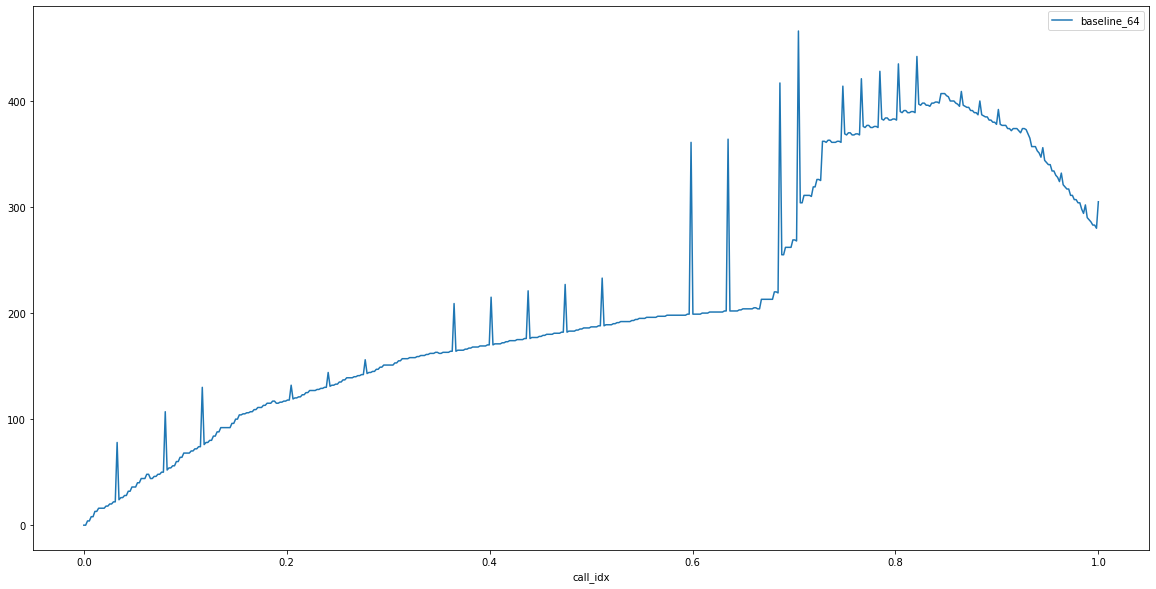

In [ ]:
plot_mem(this_mem_log)

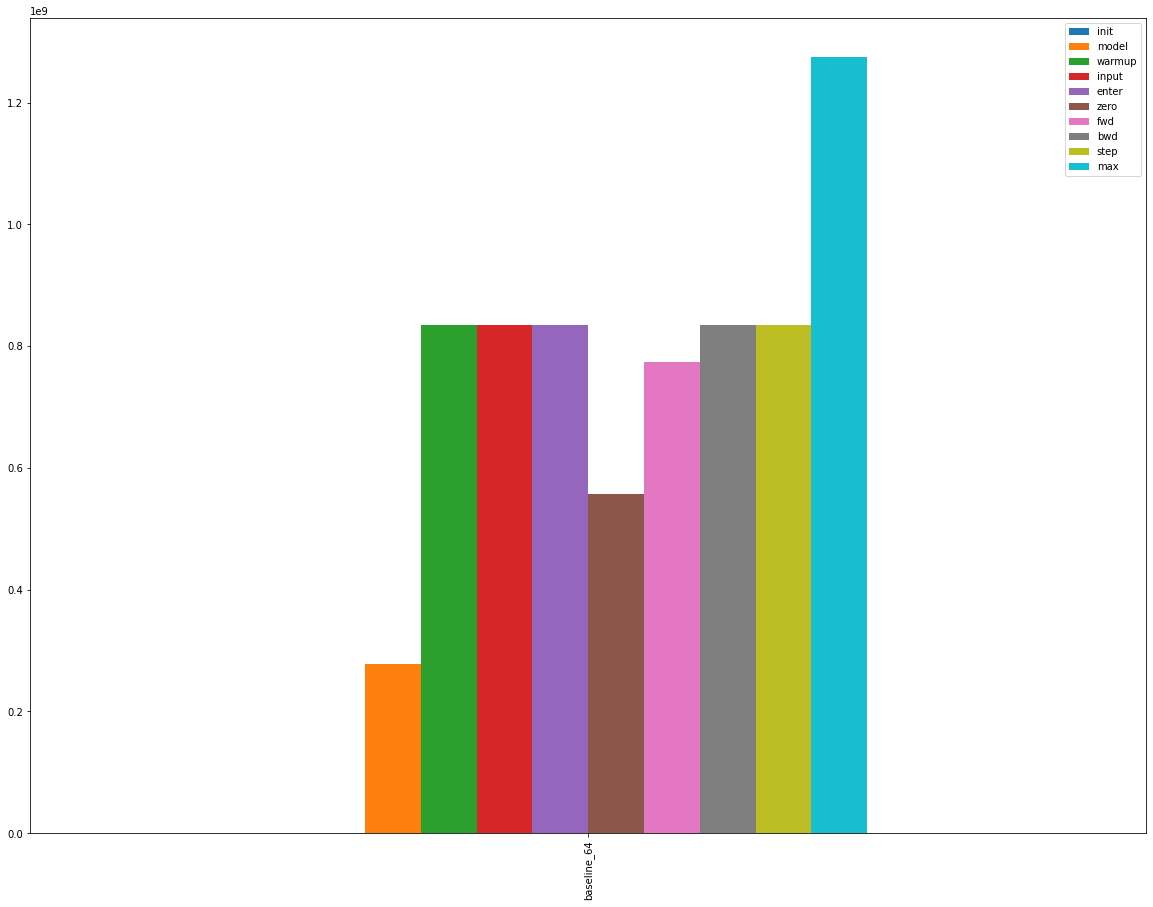

In [ ]:
plot_all_others(this_other_mems)

In [ ]:
other_mems_df

,init,model,warmup,input,enter,zero,fwd,bwd,step,max
baseline_64,0,277931520,834374144,834374144,834374144,557660672,773934592,834630656,834630656,1275415552


## Pruning

In [ ]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
exp = "sparse90_256"
wrn = WideResNet()
_, this_mem_log, this_other_mems = train(wrn, nn.CrossEntropyLoss(),
                                         wrn_dataloader(), wrn_fwd,
                                         exp=exp, sparsity=0.9, 
                                         epochs=2, batches=50, 
                                         print_stride=10, profile_epoch=1,
                                         mem_log_batch=45, time_batch=25)
save(this_mem_log, this_other_mems, exp)

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


[1,     1] loss: 0.740
[1,    11] loss: 52.611
[1,    21] loss: 77.882
[1,    31] loss: 95.334
[1,    41] loss: 105.778
[2,     1] loss: 2.721
[2,    11] loss: 10.834
[2,    21] loss: 15.936
[2,    31] loss: 20.651
[2,    41] loss: 24.876
mem_log complete
WideResNet pre  nan
    Conv2d pre  
    Conv2d fwd  16.0
    BatchNorm2d pre  
    BatchNorm2d fwd  16.0
    ReLU pre  
    ReLU fwd  16.0
    MaxPool2d pre  
    MaxPool2d fwd  12.0
    Sequential pre  
        Bottleneck pre  
            Conv2d pre  
            Conv2d fwd  8.0
            BatchNorm2d pre  
            BatchNorm2d fwd  8.0
            ReLU pre  
            ReLU fwd  8.0
            Conv2d pre  
            Conv2d fwd  8.0
            BatchNorm2d pre  
            BatchNorm2d fwd  8.0
            ReLU pre  
            ReLU fwd  8.0
            Conv2d pre  
            Conv2d fwd  16.0
            BatchNorm2d pre  
            BatchNorm2d fwd  16.0
            Sequential pre  
                Conv2d pre  
        

## Mixed precision

In [ ]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
exp = "mp_256"
wrn = WideResNet(mp=True)
_, this_mem_log, this_other_mems = train(wrn, nn.CrossEntropyLoss(),
                                         wrn_dataloader(), wrn_fwd,
                                         exp=exp, mixed_precision=True,
                                         batches=50, print_stride=10, 
                                         profile_epoch=0, mem_log_batch=45, 
                                         time_batch=25)
save(this_mem_log, this_other_mems, exp)

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


[1,     1] loss: 0.702
[1,    11] loss: 22.834
[1,    21] loss: 58.538
[1,    31] loss: 79.511
[1,    41] loss: 86.445
mem_log complete
WideResNet pre  nan
    Conv2d pre  
    Conv2d fwd  9.0
    BatchNorm2d pre  
    BatchNorm2d fwd  8.0
    ReLU pre  
    ReLU fwd  8.0
    MaxPool2d pre  
    MaxPool2d fwd  11.0
    Sequential pre  
        Bottleneck pre  
            Conv2d pre  
            Conv2d fwd  4.0
            BatchNorm2d pre  
            BatchNorm2d fwd  4.0
            ReLU pre  
            ReLU fwd  4.0
            Conv2d pre  
            Conv2d fwd  4.0
            BatchNorm2d pre  
            BatchNorm2d fwd  4.0
            ReLU pre  
            ReLU fwd  4.0
            Conv2d pre  
            Conv2d fwd  8.0
            BatchNorm2d pre  
            BatchNorm2d fwd  8.0
            Sequential pre  
                Conv2d pre  
                Conv2d fwd  8.0
                BatchNorm2d pre  
                BatchNorm2d fwd  8.0
            Sequential fwd  
 

## FP16

In [ ]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
exp = "fp16_256"
wrn = WideResNet()
_, this_mem_log, this_other_mems = train(wrn, nn.CrossEntropyLoss(),
                                         wrn_dataloader(), wrn_fwd,
                                         exp=exp, fp16="inputs", batches=50, 
                                         print_stride=10, profile_epoch=0,
                                         mem_log_batch=45, time_batch=25)
save(this_mem_log, this_other_mems, exp)

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


[1,     1] loss: 0.714
[1,    11] loss: 61.914
[1,    21] loss: 100.579
[1,    31] loss: 115.532
[1,    41] loss: 123.073
mem_log complete
WideResNet pre  nan
    Conv2d pre  
    Conv2d fwd  8.0
    BatchNorm2d pre  
    BatchNorm2d fwd  8.0
    ReLU pre  
    ReLU fwd  8.0
    MaxPool2d pre  
    MaxPool2d fwd  10.0
    Sequential pre  
        Bottleneck pre  
            Conv2d pre  
            Conv2d fwd  4.0
            BatchNorm2d pre  
            BatchNorm2d fwd  4.0
            ReLU pre  
            ReLU fwd  4.0
            Conv2d pre  
            Conv2d fwd  4.0
            BatchNorm2d pre  
            BatchNorm2d fwd  4.0
            ReLU pre  
            ReLU fwd  4.0
            Conv2d pre  
            Conv2d fwd  8.0
            BatchNorm2d pre  
            BatchNorm2d fwd  8.0
            Sequential pre  
                Conv2d pre  
                Conv2d fwd  8.0
                BatchNorm2d pre  
                BatchNorm2d fwd  8.0
            Sequential fwd 

## Checkpointing

### Over-checkpointing (Layer)

In [ ]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
exp = "chklayer_256"
wrn = WideResNet(chk=1)
_, this_mem_log, this_other_mems = train(wrn, nn.CrossEntropyLoss(),
                                         wrn_dataloader(), wrn_fwd,
                                         exp=exp, batches=50, print_stride=10,
                                         profile_epoch=0, mem_log_batch=45, time_batch=25)
save(this_mem_log, this_other_mems, exp)

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


[1,     1] loss: 0.701
[1,    11] loss: 60.777
[1,    21] loss: 93.029
[1,    31] loss: 105.964
[1,    41] loss: 112.542
mem_log complete
WideResNet pre  nan
    Conv2d pre  
    Conv2d fwd  16.0
    BatchNorm2d pre  
    BatchNorm2d fwd  16.0
    ReLU pre  
    ReLU fwd  16.0
    MaxPool2d pre  
    MaxPool2d fwd  12.0
    Sequential pre  
        Bottleneck pre  
            Conv2d pre  
            Conv2d fwd  8.0
            BatchNorm2d pre  
            BatchNorm2d fwd  8.0
            ReLU pre  -8.0
            ReLU fwd  8.0
            Conv2d pre  -9.0
            Conv2d fwd  8.0
            BatchNorm2d pre  -8.0
            BatchNorm2d fwd  8.0
            ReLU pre  -9.0
            ReLU fwd  8.0
            Conv2d pre  -8.0
            Conv2d fwd  16.0
            BatchNorm2d pre  -9.0
            BatchNorm2d fwd  16.0
            Sequential pre  -16.0
                Conv2d pre  
                Conv2d fwd  16.0
                BatchNorm2d pre  
                BatchNorm2d fw

### Ideal checkpointing (Res)

In [ ]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
exp = "chkres_256"
wrn = WideResNet(chk=2)
_, this_mem_log, this_other_mems = train(wrn, nn.CrossEntropyLoss(),
                                         wrn_dataloader(), wrn_fwd,
                                         exp=exp, batches=50, print_stride=10,
                                         profile_epoch=0, mem_log_batch=45, time_batch=25)
save(this_mem_log, this_other_mems, exp)

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


[1,     1] loss: 0.734
[1,    11] loss: 52.909
[1,    21] loss: 78.409
[1,    31] loss: 88.242
[1,    41] loss: 97.641
mem_log complete
WideResNet pre  nan
    Conv2d pre  
    Conv2d fwd  16.0
    BatchNorm2d pre  
    BatchNorm2d fwd  16.0
    ReLU pre  
    ReLU fwd  16.0
    MaxPool2d pre  
    MaxPool2d fwd  12.0
    Bottleneck pre  
        Conv2d pre  
        Conv2d fwd  8.0
        BatchNorm2d pre  
        BatchNorm2d fwd  8.0
        ReLU pre  -8.0
        ReLU fwd  8.0
        Conv2d pre  -8.0
        Conv2d fwd  8.0
        BatchNorm2d pre  -8.0
        BatchNorm2d fwd  8.0
        ReLU pre  -8.0
        ReLU fwd  8.0
        Conv2d pre  -8.0
        Conv2d fwd  16.0
        BatchNorm2d pre  -8.0
        BatchNorm2d fwd  16.0
        Sequential pre  -16.0
            Conv2d pre  
            Conv2d fwd  16.0
            BatchNorm2d pre  
            BatchNorm2d fwd  16.0
        Sequential fwd  -16.0
        ReLU pre  
        ReLU fwd  16.0
    Bottleneck fwd  -32.0
    B

## Baseline + 64

In [ ]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
exp = "baseline_64"
wrn = WideResNet()
_, this_mem_log, this_other_mems = train(wrn, nn.CrossEntropyLoss(),
                                         wrn_dataloader(64), wrn_fwd,
                                         exp=exp, epochs=1, batches=50,
                                         print_stride=10, profile_epoch=0,
                                         mem_log_batch=45, time_batch=25)
save(this_mem_log, this_other_mems, exp)
mem_log_df = mem_log_df.append(this_mem_log)
other_mems_df = other_mems_df.append(this_other_mems)

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


[1,     1] loss: 0.724
[1,    11] loss: 55.852
[1,    21] loss: 99.819
[1,    31] loss: 127.666
[1,    41] loss: 141.528
mem_log complete
WideResNet pre  nan
    Conv2d pre  
    Conv2d fwd  4.0
    BatchNorm2d pre  
    BatchNorm2d fwd  4.0
    ReLU pre  
    ReLU fwd  4.0
    MaxPool2d pre  
    MaxPool2d fwd  3.0
    Sequential pre  
        Bottleneck pre  
            Conv2d pre  
            Conv2d fwd  2.0
            BatchNorm2d pre  
            BatchNorm2d fwd  2.0
            ReLU pre  
            ReLU fwd  2.0
            Conv2d pre  
            Conv2d fwd  2.0
            BatchNorm2d pre  
            BatchNorm2d fwd  2.0
            ReLU pre  
            ReLU fwd  2.0
            Conv2d pre  
            Conv2d fwd  4.0
            BatchNorm2d pre  
            BatchNorm2d fwd  4.0
            Sequential pre  
                Conv2d pre  
                Conv2d fwd  4.0
                BatchNorm2d pre  
                BatchNorm2d fwd  4.0
            Sequential fwd  


## Baseline + 16

In [ ]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
exp = "baseline_16"
wrn = WideResNet()
_, this_mem_log, this_other_mems = train(wrn, nn.CrossEntropyLoss(),
                                         wrn_dataloader(16), wrn_fwd,
                                         exp=exp, epochs=1, batches=50,
                                         print_stride=10, profile_epoch=0,
                                         mem_log_batch=45, time_batch=25)
save(this_mem_log, this_other_mems, exp)

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


[1,     1] loss: 0.752
[1,    11] loss: 116.483
[1,    21] loss: 188.530
[1,    31] loss: 228.749
[1,    41] loss: 234.889
mem_log complete
WideResNet pre  nan
    Conv2d pre  
    Conv2d fwd  1.0
    BatchNorm2d pre  
    BatchNorm2d fwd  1.0
    ReLU pre  
    ReLU fwd  1.0
    MaxPool2d pre  
    MaxPool2d fwd  
    Sequential pre  
        Bottleneck pre  
            Conv2d pre  
            Conv2d fwd  
            BatchNorm2d pre  
            BatchNorm2d fwd  
            ReLU pre  
            ReLU fwd  
            Conv2d pre  
            Conv2d fwd  
            BatchNorm2d pre  
            BatchNorm2d fwd  
            ReLU pre  
            ReLU fwd  
            Conv2d pre  
            Conv2d fwd  1.0
            BatchNorm2d pre  
            BatchNorm2d fwd  1.0
            Sequential pre  
                Conv2d pre  
                Conv2d fwd  1.0
                BatchNorm2d pre  
                BatchNorm2d fwd  1.0
            Sequential fwd  
            ReLU pr

NameError: ignored

## Chk-Res + 64

In [ ]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
exp = "chkres_64"
wrn = WideResNet(chk=2)
_, this_mem_log, this_other_mems = train(wrn, nn.CrossEntropyLoss(),
                                         wrn_dataloader(64), wrn_fwd,
                                         exp=exp, batches=50, print_stride=10,
                                         profile_epoch=0, mem_log_batch=45, time_batch=25)
save(this_mem_log, this_other_mems, exp)

## Chk-Res + MP + 256

In [ ]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
exp = "chkres_mp_256"
wrn = WideResNet(mp=True, chk=2)
_, this_mem_log, this_other_mems = train(wrn, nn.CrossEntropyLoss(),
                                         wrn_dataloader(), wrn_fwd,
                                         exp=exp, mixed_precision=True,
                                         batches=50, print_stride=10, 
                                         profile_epoch=0, mem_log_batch=45, time_batch=25)
save(this_mem_log, this_other_mems, exp)

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


[1,     1] loss: 0.775
[1,    11] loss: 27.147
[1,    21] loss: 74.606
[1,    31] loss: 90.339
[1,    41] loss: 99.186
mem_log complete
WideResNet pre  nan
    Conv2d pre  
    Conv2d fwd  10.0
    BatchNorm2d pre  
    BatchNorm2d fwd  8.0
    ReLU pre  
    ReLU fwd  8.0
    MaxPool2d pre  
    MaxPool2d fwd  10.0
    Bottleneck pre  
        Conv2d pre  
        Conv2d fwd  4.0
        BatchNorm2d pre  
        BatchNorm2d fwd  4.0
        ReLU pre  -4.0
        ReLU fwd  4.0
        Conv2d pre  -5.0
        Conv2d fwd  4.0
        BatchNorm2d pre  -4.0
        BatchNorm2d fwd  4.0
        ReLU pre  -5.0
        ReLU fwd  4.0
        Conv2d pre  -4.0
        Conv2d fwd  8.0
        BatchNorm2d pre  -5.0
        BatchNorm2d fwd  8.0
        Sequential pre  -8.0
            Conv2d pre  
            Conv2d fwd  8.0
            BatchNorm2d pre  
            BatchNorm2d fwd  8.0
        Sequential fwd  -8.0
        ReLU pre  
        ReLU fwd  8.0
    Bottleneck fwd  -16.0
    Bottleneck

## Chk-Res + FP16 + 256

In [ ]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
exp = "chkres_fp16_256"
wrn = WideResNet(chk=2)
_, this_mem_log, this_other_mems = train(wrn, nn.CrossEntropyLoss(),
                                         wrn_dataloader(), wrn_fwd,
                                         exp=exp, fp16="inputs", batches=50, 
                                         print_stride=10, profile_epoch=0,
                                         mem_log_batch=45, time_batch=25)
save(this_mem_log, this_other_mems, exp)

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


[1,     1] loss: 0.764
[1,    11] loss: 37.723
[1,    21] loss: 80.188
[1,    31] loss: 103.088
[1,    41] loss: 113.073
mem_log complete
WideResNet pre  nan
    Conv2d pre  
    Conv2d fwd  9.0
    BatchNorm2d pre  
    BatchNorm2d fwd  8.0
    ReLU pre  
    ReLU fwd  8.0
    MaxPool2d pre  
    MaxPool2d fwd  10.0
    Sequential pre  
        Bottleneck pre  
            Conv2d pre  
            Conv2d fwd  4.0
            BatchNorm2d pre  
            BatchNorm2d fwd  4.0
            ReLU pre  -4.0
            ReLU fwd  4.0
            Conv2d pre  -4.0
            Conv2d fwd  4.0
            BatchNorm2d pre  -4.0
            BatchNorm2d fwd  4.0
            ReLU pre  -4.0
            ReLU fwd  4.0
            Conv2d pre  -4.0
            Conv2d fwd  8.0
            BatchNorm2d pre  -4.0
            BatchNorm2d fwd  8.0
            Sequential pre  -8.0
                Conv2d pre  
                Conv2d fwd  8.0
                BatchNorm2d pre  
                BatchNorm2d fwd  8.0


## Chk-Res + MP + 64

In [ ]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
exp = "chkres_mp_64"
wrn = WideResNet(mp=True, chk=2)
_, this_mem_log, this_other_mems = train(wrn, nn.CrossEntropyLoss(),
                                         wrn_dataloader(64), wrn_fwd,
                                         exp=exp, mixed_precision=True,
                                         batches=50, print_stride=10, 
                                         profile_epoch=0, mem_log_batch=45, time_batch=25)
save(this_mem_log, this_other_mems, exp)

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


[1,     1] loss: 0.748
[1,    11] loss: 21.360
[1,    21] loss: 73.219
[1,    31] loss: 94.289
[1,    41] loss: 109.903
mem_log complete
WideResNet pre  nan
    Conv2d pre  
    Conv2d fwd  2.0
    BatchNorm2d pre  
    BatchNorm2d fwd  2.0
    ReLU pre  
    ReLU fwd  2.0
    MaxPool2d pre  
    MaxPool2d fwd  2.0
    Bottleneck pre  
        Conv2d pre  
        Conv2d fwd  1.0
        BatchNorm2d pre  
        BatchNorm2d fwd  1.0
        ReLU pre  -1.0
        ReLU fwd  1.0
        Conv2d pre  -1.0
        Conv2d fwd  1.0
        BatchNorm2d pre  -1.0
        BatchNorm2d fwd  1.0
        ReLU pre  -1.0
        ReLU fwd  1.0
        Conv2d pre  -1.0
        Conv2d fwd  2.0
        BatchNorm2d pre  -1.0
        BatchNorm2d fwd  2.0
        Sequential pre  -2.0
            Conv2d pre  
            Conv2d fwd  2.0
            BatchNorm2d pre  
            BatchNorm2d fwd  2.0
        Sequential fwd  -2.0
        ReLU pre  
        ReLU fwd  2.0
    Bottleneck fwd  -4.0
    Bottleneck p

## Chk-Res + FP16 + 64

In [ ]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
exp = "chkres_fp16_64"
wrn = WideResNet(chk=2)
_, this_mem_log, this_other_mems = train(wrn, nn.CrossEntropyLoss(),
                                         wrn_dataloader(64), wrn_fwd,
                                         exp=exp, fp16="inputs", batches=50, 
                                         print_stride=10, profile_epoch=0,
                                         mem_log_batch=45, time_batch=25)
save(this_mem_log, this_other_mems, exp)

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


[1,     1] loss: 0.719
[1,    11] loss: 49.446
[1,    21] loss: 72.255
[1,    31] loss: 84.929
[1,    41] loss: 96.957
mem_log complete
WideResNet pre  nan
    Conv2d pre  
    Conv2d fwd  2.0
    BatchNorm2d pre  
    BatchNorm2d fwd  2.0
    ReLU pre  
    ReLU fwd  2.0
    MaxPool2d pre  
    MaxPool2d fwd  2.0
    Sequential pre  
        Bottleneck pre  
            Conv2d pre  
            Conv2d fwd  1.0
            BatchNorm2d pre  
            BatchNorm2d fwd  1.0
            ReLU pre  -1.0
            ReLU fwd  1.0
            Conv2d pre  -1.0
            Conv2d fwd  1.0
            BatchNorm2d pre  -1.0
            BatchNorm2d fwd  1.0
            ReLU pre  -1.0
            ReLU fwd  1.0
            Conv2d pre  -1.0
            Conv2d fwd  2.0
            BatchNorm2d pre  -1.0
            BatchNorm2d fwd  2.0
            Sequential pre  -3.0
                Conv2d pre  
                Conv2d fwd  2.0
                BatchNorm2d pre  
                BatchNorm2d fwd  2.0
   

# GPU Experiments 2 - Transformer

In [ ]:
mem_log_df = pd.DataFrame()
other_mems_df = pd.DataFrame()

## Baseline

In [ ]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
exp = "baseline_256"
transformer = Transformer()
_, this_mem_log, this_other_mems = train(transformer, TransformerCrossEntropyLoss(),
                                         transformer_dataloader(), transformer_fwd,
                                         exp=exp, epochs=1, batches=50,
                                         print_stride=10, profile_epoch=0,
                                         mem_log_batch=45, time_batch=25)
save(this_mem_log, this_other_mems, exp, model="transformer")

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


[1,     1] loss: 0.667
[1,    11] loss: 7.207
[1,    21] loss: 13.568
[1,    31] loss: 19.842
[1,    41] loss: 26.094
mem_log complete
Transformer pre  nan
    TransformerEncoder pre  
        TransformerEncoderLayer pre  
            MultiheadAttention pre  
            MultiheadAttention fwd  43.0
            Dropout pre  -1.0
            Dropout fwd  6.0
            LayerNorm pre  
            LayerNorm fwd  5.0
            Linear pre  
            Linear fwd  20.0
            Dropout pre  20.0
            Dropout fwd  25.0
            Linear pre  -20.0
            Linear fwd  5.0
            Dropout pre  -5.0
            Dropout fwd  7.0
            LayerNorm pre  
            LayerNorm fwd  5.0
        TransformerEncoderLayer fwd  -5.0
        TransformerEncoderLayer pre  
            MultiheadAttention pre  
            MultiheadAttention fwd  43.0
            Dropout pre  -1.0
            Dropout fwd  7.0
            LayerNorm pre  
            LayerNorm fwd  5.0
            Lin

## Mixed precision

In [ ]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
exp = "mp_256"
transformer = Transformer(mp=True)
_, this_mem_log, this_other_mems = train(transformer, TransformerCrossEntropyLoss(),
                                         transformer_dataloader(), transformer_fwd,
                                         exp=exp, mixed_precision=True,
                                         batches=50, print_stride=10, 
                                         profile_epoch=0, mem_log_batch=45, time_batch=25)
save(this_mem_log, this_other_mems, exp, model="transformer")

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


[1,     1] loss: 0.668
[1,    11] loss: 7.184
[1,    21] loss: 13.510
[1,    31] loss: 19.756
[1,    41] loss: 25.980
mem_log complete
Transformer pre  nan
    TransformerEncoder pre  
        TransformerEncoderLayer pre  
            MultiheadAttention pre  
            MultiheadAttention fwd  26.0
            Dropout pre  -1.0
            Dropout fwd  3.0
            LayerNorm pre  2.0
            LayerNorm fwd  5.0
            Linear pre  
            Linear fwd  14.0
            Dropout pre  10.0
            Dropout fwd  15.0
            Linear pre  -10.0
            Linear fwd  4.0
            Dropout pre  -3.0
            Dropout fwd  4.0
            LayerNorm pre  -3.0
            LayerNorm fwd  5.0
        TransformerEncoderLayer fwd  -3.0
        TransformerEncoderLayer pre  
            MultiheadAttention pre  
            MultiheadAttention fwd  26.0
            Dropout pre  -1.0
            Dropout fwd  4.0
            LayerNorm pre  2.0
            LayerNorm fwd  5.0
     

## FP16

In [ ]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
exp = "fp16"
transformer = Transformer()
_, this_mem_log, this_other_mems = train(transformer, TransformerCrossEntropyLoss(),
                                         transformer_dataloader, transformer_fwd,
                                         exp=exp, fp16="inputs", batches=50, 
                                         print_stride=10, profile_epoch=0,
                                         mem_log_batch=45)
save(this_mem_log, this_other_mems, exp, model="transformer")

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


RuntimeError: ignored

## Checkpointing

In [ ]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
exp = "chk_256"
transformer = Transformer(chk=True)
_, this_mem_log, this_other_mems = train(transformer, TransformerCrossEntropyLoss(),
                                         transformer_dataloader(), transformer_fwd,
                                         exp=exp, batches=50, print_stride=10,
                                         profile_epoch=0, mem_log_batch=45, time_batch=25)
save(this_mem_log, this_other_mems, exp, model="transformer")

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


[1,     1] loss: 0.667
[1,    11] loss: 7.192
[1,    21] loss: 13.551
[1,    31] loss: 19.822
[1,    41] loss: 26.052
mem_log complete
Transformer pre  nan
    TransformerEncoderCheckpoint pre  
        TransformerEncoderLayer pre  
            MultiheadAttention pre  
            MultiheadAttention fwd  5.0
            Dropout pre  -1.0
            Dropout fwd  5.0
            LayerNorm pre  1.0
            LayerNorm fwd  5.0
            Linear pre  -6.0
            Linear fwd  20.0
            Dropout pre  
            Dropout fwd  20.0
            Linear pre  -20.0
            Linear fwd  6.0
            Dropout pre  -25.0
            Dropout fwd  5.0
            LayerNorm pre  -5.0
            LayerNorm fwd  5.0
        TransformerEncoderLayer fwd  -11.0
        TransformerEncoderLayer pre  
            MultiheadAttention pre  
            MultiheadAttention fwd  5.0
            Dropout pre  -1.0
            Dropout fwd  6.0
            LayerNorm pre  -1.0
            LayerNorm fwd

## Baseline 64

In [ ]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
exp = "baseline_64"
transformer = Transformer()
_, this_mem_log, this_other_mems = train(transformer, TransformerCrossEntropyLoss(),
                                         transformer_dataloader(64), transformer_fwd,
                                         exp=exp, epochs=1, batches=50,
                                         print_stride=10, profile_epoch=0,
                                         mem_log_batch=45, time_batch=25)
save(this_mem_log, this_other_mems, exp, model="transformer")

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


[1,     1] loss: 0.665
[1,    11] loss: 7.231
[1,    21] loss: 13.670
[1,    31] loss: 20.039
[1,    41] loss: 26.366
mem_log complete
Transformer pre  nan
    TransformerEncoder pre  
        TransformerEncoderLayer pre  
            MultiheadAttention pre  
            MultiheadAttention fwd  13.0
            Dropout pre  -1.0
            Dropout fwd  2.0
            LayerNorm pre  
            LayerNorm fwd  2.0
            Linear pre  
            Linear fwd  5.0
            Dropout pre  5.0
            Dropout fwd  7.0
            Linear pre  -5.0
            Linear fwd  2.0
            Dropout pre  -2.0
            Dropout fwd  2.0
            LayerNorm pre  
            LayerNorm fwd  1.0
        TransformerEncoderLayer fwd  -2.0
        TransformerEncoderLayer pre  
            MultiheadAttention pre  
            MultiheadAttention fwd  14.0
            Dropout pre  -1.0
            Dropout fwd  2.0
            LayerNorm pre  
            LayerNorm fwd  2.0
            Linear 

## MP 64

In [ ]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
exp = "mp_64"
transformer = Transformer(mp=True)
_, this_mem_log, this_other_mems = train(transformer, TransformerCrossEntropyLoss(),
                                         transformer_dataloader(64), transformer_fwd,
                                         exp=exp, mixed_precision=True,
                                         batches=50, print_stride=10, 
                                         profile_epoch=0, mem_log_batch=45, time_batch=25)
save(this_mem_log, this_other_mems, exp, model="transformer")

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


[1,     1] loss: 0.669
[1,    11] loss: 7.228
[1,    21] loss: 13.665
[1,    31] loss: 20.026
[1,    41] loss: 26.328
mem_log complete
Transformer pre  nan
    TransformerEncoder pre  
        TransformerEncoderLayer pre  
            MultiheadAttention pre  
            MultiheadAttention fwd  8.0
            Dropout pre  -1.0
            Dropout fwd  
            LayerNorm pre  
            LayerNorm fwd  1.0
            Linear pre  
            Linear fwd  5.0
            Dropout pre  3.0
            Dropout fwd  4.0
            Linear pre  -3.0
            Linear fwd  2.0
            Dropout pre  -1.0
            Dropout fwd  
            LayerNorm pre  -1.0
            LayerNorm fwd  1.0
        TransformerEncoderLayer fwd  -1.0
        TransformerEncoderLayer pre  
            MultiheadAttention pre  
            MultiheadAttention fwd  8.0
            Dropout pre  -1.0
            Dropout fwd  
            LayerNorm pre  1.0
            LayerNorm fwd  2.0
            Linear pre 

## Chk 64

In [ ]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
exp = "chk_64"
transformer = Transformer(chk=True)
_, this_mem_log, this_other_mems = train(transformer, TransformerCrossEntropyLoss(),
                                         transformer_dataloader(64), transformer_fwd,
                                         exp=exp, batches=50, print_stride=10,
                                         profile_epoch=0, mem_log_batch=45, time_batch=25)
save(this_mem_log, this_other_mems, exp, model="transformer")

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


[1,     1] loss: 0.668
[1,    11] loss: 7.254
[1,    21] loss: 13.690
[1,    31] loss: 20.035
[1,    41] loss: 26.327
mem_log complete
Transformer pre  nan
    TransformerEncoderCheckpoint pre  
        TransformerEncoderLayer pre  
            MultiheadAttention pre  
            MultiheadAttention fwd  2.0
            Dropout pre  -1.0
            Dropout fwd  1.0
            LayerNorm pre  
            LayerNorm fwd  1.0
            Linear pre  -2.0
            Linear fwd  5.0
            Dropout pre  
            Dropout fwd  5.0
            Linear pre  -5.0
            Linear fwd  1.0
            Dropout pre  -7.0
            Dropout fwd  2.0
            LayerNorm pre  -2.0
            LayerNorm fwd  1.0
        TransformerEncoderLayer fwd  -4.0
        TransformerEncoderLayer pre  
            MultiheadAttention pre  
            MultiheadAttention fwd  2.0
            Dropout pre  -1.0
            Dropout fwd  1.0
            LayerNorm pre  
            LayerNorm fwd  1.0
      

## Chk + MP

In [ ]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
exp = "chk_mp_256"
transformer = Transformer(mp=True,chk=True)
_, this_mem_log, this_other_mems = train(transformer, TransformerCrossEntropyLoss(),
                                         transformer_dataloader(), transformer_fwd,
                                         exp=exp, mixed_precision=True, batches=50, print_stride=10,
                                         profile_epoch=0, mem_log_batch=45, time_batch=25)
save(this_mem_log, this_other_mems, exp, model="transformer")

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


[1,     1] loss: 0.667
[1,    11] loss: 7.195
[1,    21] loss: 13.562
[1,    31] loss: 19.852
[1,    41] loss: 26.078
mem_log complete
Transformer pre  nan
    TransformerEncoderCheckpoint pre  
        TransformerEncoderLayer pre  
            MultiheadAttention pre  
            MultiheadAttention fwd  4.0
            Dropout pre  -1.0
            Dropout fwd  2.0
            LayerNorm pre  2.0
            LayerNorm fwd  5.0
            Linear pre  -5.0
            Linear fwd  12.0
            Dropout pre  
            Dropout fwd  10.0
            Linear pre  -10.0
            Linear fwd  4.0
            Dropout pre  -13.0
            Dropout fwd  2.0
            LayerNorm pre  -3.0
            LayerNorm fwd  5.0
        TransformerEncoderLayer fwd  -8.0
        TransformerEncoderLayer pre  
            MultiheadAttention pre  
            MultiheadAttention fwd  5.0
            Dropout pre  -1.0
            Dropout fwd  2.0
            LayerNorm pre  2.0
            LayerNorm fwd  

## Chk + MP + 64

In [ ]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
exp = "chk_mp_64"
transformer = Transformer(mp=True,chk=True)
_, this_mem_log, this_other_mems = train(transformer, TransformerCrossEntropyLoss(),
                                         transformer_dataloader(64), transformer_fwd,
                                         exp=exp, mixed_precision=True, batches=50, print_stride=10,
                                         profile_epoch=0, mem_log_batch=45, time_batch=25)
save(this_mem_log, this_other_mems, exp, model="transformer")

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


[1,     1] loss: 0.671
[1,    11] loss: 7.245
[1,    21] loss: 13.680
[1,    31] loss: 20.053
[1,    41] loss: 26.391
mem_log complete
Transformer pre  nan
    TransformerEncoderCheckpoint pre  
        TransformerEncoderLayer pre  
            MultiheadAttention pre  
            MultiheadAttention fwd  3.0
            Dropout pre  -1.0
            Dropout fwd  
            LayerNorm pre  1.0
            LayerNorm fwd  2.0
            Linear pre  -2.0
            Linear fwd  5.0
            Dropout pre  -1.0
            Dropout fwd  3.0
            Linear pre  -3.0
            Linear fwd  2.0
            Dropout pre  -5.0
            Dropout fwd  
            LayerNorm pre  -1.0
            LayerNorm fwd  2.0
        TransformerEncoderLayer fwd  -3.0
        TransformerEncoderLayer pre  
            MultiheadAttention pre  
            MultiheadAttention fwd  3.0
            Dropout pre  -1.0
            Dropout fwd  
            LayerNorm pre  1.0
            LayerNorm fwd  2.0
     

# Evaluation

In [3]:
def x_adj(data, df_, normalize_call_idx=True,time=-1.0):
    if time < 0.0:
        scale_factor = 1.0
    else:
        scale_factor = 1000.0 * time
    if normalize_call_idx:
        return scale_factor * data / df_.call_idx.max()

def y_adj(data, df_, normalize_mem_all=True, vadj=0):
    if normalize_mem_all:
        return (data - df_[df_.call_idx == df_.call_idx.min()].mem_all.iloc[0] + vadj) // 2 ** 20

def get_time(df_, exp):
    return (df_['endtime'] - df_['starttime']).loc[exp]

def get_max(df, exp, col):
    max_id = df[df.exp == exp][col].idxmax(axis=1)
    if isinstance (max_id, pd.Series):
        max_id = max_id.iloc[0]
    max_row = df.iloc[max_id]
    return max_row['call_idx'], max_row[col]

def plot_mem(
        df,
        om_df,
        exps=None,
        labels=None,
        normalize_call_idx=True,
        normalize_mem_all=True,
        filter_fwd=False,
        filter_pre=False,
        return_df=False,
        output_file=None,
        vlines=[],
        hlines=[],
        annotations=[],
        vadj=0
):
    if exps is None:
        exps = df.exp.drop_duplicates()
    if labels is None:
        labels = exps

    small_font = 16
    big_font = 20
    fig, ax = plt.subplots(figsize=(8,8))
    for exp, label in zip(exps, labels):
        df_ = df[df.exp == exp]

        time = get_time(om_df, exp)
        wga_df = get_weights_grad_acts(om_df).loc[exp]
        weights = wga_df['weights']

        max_x, max_y = get_max(df_, exp, 'mem_all')
        max_x = x_adj(max_x, df_, normalize_call_idx, time)
        max_y = y_adj(max_y, df_, normalize_mem_all, weights)

        # if normalize_call_idx:
        #     df_.call_idx = df_.call_idx / df_.call_idx.max()
        df_.call_idx = x_adj(df_.call_idx, df_, normalize_call_idx, time)

        # if normalize_mem_all:
        #     df_.mem_all = df_.mem_all - df_[df_.call_idx == df_.call_idx.min()].mem_all.iloc[0]
        #     df_.mem_all = (df_.mem_all + vadj) // 2 ** 20
            # df_.max_mem_all = df_.max_mem_all - df_[df_.call_idx == df_.call_idx.min()].max_mem_all.iloc[0]
            # df_.max_mem_all = (df_.max_mem_all + vadj) // 2 ** 20
        df_.mem_all = y_adj(df_.mem_all, df_, normalize_mem_all, weights)
        
        if filter_fwd:
            layer_idx = 0
            callidx_stop = df_[(df_["layer_idx"] == layer_idx) & (df_["hook_type"] == "fwd")]["call_idx"].iloc[0]
            df_ = df_[df_["call_idx"] <= callidx_stop]
            # df_ = df_[df_.call_idx < df_[df_.layer_idx=='bwd'].call_idx.min()]

        if filter_pre:
            df_ = df_[(df_["hook_type"] == "fwd") | (df_["hook_type"] == "bwd")]
            print(df_.hook_type.head())

        df_.plot(ax=ax, x='call_idx', y='mem_all', label=label)

        ax.annotate(max_y, xy=(max_x,max_y),fontsize=big_font)

        # ax = df_.plot(ax=ax, x='call_idx', y='max_mem_all', label=exp)
      
    if output_file:
        ax.get_figure().savefig(output_file)

    for (label, vline) in vlines:
        ax.axvline(vline, lw=1, ls="--")
        plt.text(vline + 0.1,0,label,rotation=90)
    for (label, hline) in hlines:
        hline = hline // 2 ** 20
        ax.axhline(hline, lw=2, alpha=0.5, ls="--")
        plt.text(0, hline - 40,label,fontsize=small_font)

    ax.set_xlabel('Computation Time / ms', fontsize=big_font)
    ax.set_ylabel('GPU Memory Consumption / MB', fontsize=big_font)
    ax.tick_params(axis='both', which='major', labelsize=small_font)
    lgd = ax.legend(fontsize=small_font)

    if return_df:
        return df_

def get_weights_grad_acts(df, exps=None):
    if exps is None:
        df_ = df
    else:
        df_ = df.loc[exps]
    # df_ = df_.diff(axis=1).drop(['init', 'warmup', 'input', 'enter'], axis=1)
    ret_df = pd.DataFrame()
    ret_df['adj'] = df_['model'] - df_['init'] - df['zero']
    ret_df['weights'] = df_['model'] - df_['init']
    ret_df['gradients'] = df_['bwd'] - df_['zero']
    ret_df['activations'] = df_['fwd'] - df_['zero']
    return ret_df

def plot_mem_lines(df, om_df, baseline_exp, exps=None, labels=None):
    wga_df = get_weights_grad_acts(om_df).loc[baseline_exp]
    adj = wga_df['adj']
    weights = wga_df['weights']
    activations = wga_df['activations']
    gradients = wga_df['gradients']
    hlines=[
            ('weights', weights),
            ('weights + gradients', weights + gradients),
            ('weights + activations', weights + activations),
            ('weights + gradients + activations', weights + gradients + activations)
            ]
    # max_id, max_mem = get_max(df, baseline_exp, 'mem_all')
    # max_id = x_adj(max_id, df[df.exp == baseline_exp], True)
    # max_mem = y_adj(max_mem, df[df.exp == baseline_exp], True, weights)
    # annotations = [(max_mem, (max_id, max_mem))]
    # return annotations
    plot_mem(df, om_df, exps=exps, labels=labels, hlines=hlines, vadj=weights)

In [4]:
def get_dfs(exps, model):
    mem_log_df = pd.DataFrame()
    other_mems_df = pd.DataFrame()
    for exp in exps:
        this_mem_log = pd.read_csv('mem_log_df_' + exp + '_' + model + '.csv')
        this_other_mems = pd.read_csv('other_mems_df_' + exp + '_' + model + '.csv')
        this_other_mems = this_other_mems.set_index(this_other_mems.iloc[:,0]).rename_axis("exp").drop(this_other_mems.columns[0], 1)
        mem_log_df = mem_log_df.append(this_mem_log)
        other_mems_df = other_mems_df.append(this_other_mems)
    return mem_log_df, other_mems_df

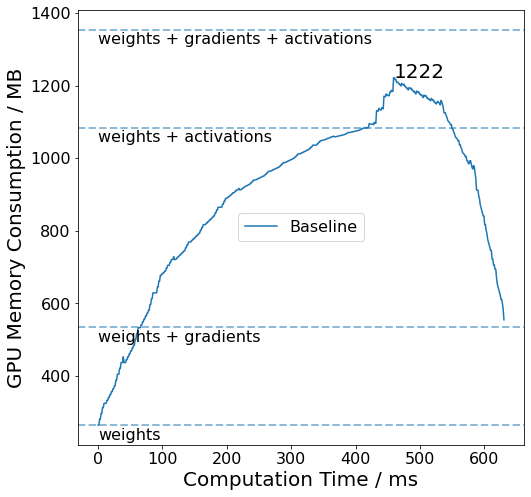

In [ ]:
exps = (
    'baseline_256',
    # 'sparse90_256',
    # 'mp_256',
    # 'fp16_256',
    # 'chklayer_256',
    # 'chkres_256',
    # 'baseline_64',
    # 'chkres_64',
    # 'chkres_mp_256',
    # 'chkres_fp16_256',
    # 'chkres_mp_64',
    # 'chkres_fp16_64',
)
mem_log_df, other_mems_df = get_dfs(exps, 'wrn')
plot_mem_lines(mem_log_df, other_mems_df, 'baseline_256', labels=["Baseline"])

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

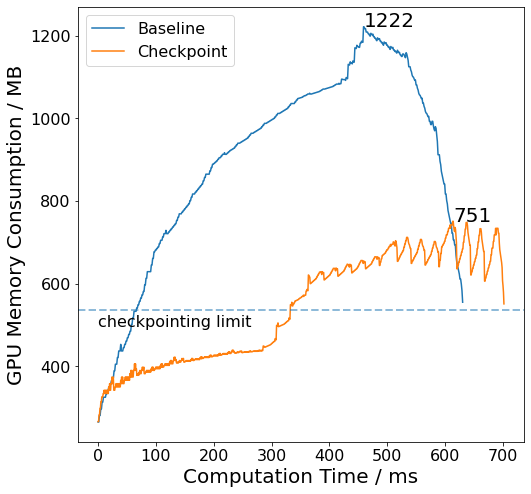

In [ ]:
exps = (
    'baseline_256',
    # 'sparse90_256',
    # 'mp_256',
    # 'fp16_256',
    # 'chklayer_256',
    'chkres_256',
    # 'baseline_64',
    # 'chkres_64',
    # 'chkres_mp_256',
    # 'chkres_fp16_256',
    # 'chkres_mp_64',
    # 'chkres_fp16_64',
)
mem_log_df, other_mems_df = get_dfs(exps, 'wrn')
plot_mem(mem_log_df, other_mems_df,labels=['Baseline', 'Checkpoint'],hlines=[('checkpointing limit',561240064)])

In [ ]:
other_mems_df

,init,model,starttime,endtime,warmup,input,enter,zero,fwd,bwd,step,max
exp,,,,,,,,,,,,
baseline_256,0,277931520,1.610640e+09,1.610640e+09,842764288,842764288,842764288,560480256,1419512832,843788800,843788800,1737236480
chkres_256,0,278980096,1.610641e+09,1.610641e+09,835686400,835686400,835686400,558710784,739697664,836710912,836710912,1082718208


In [ ]:
843788800 - 560480256 + 277931520

561240064

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

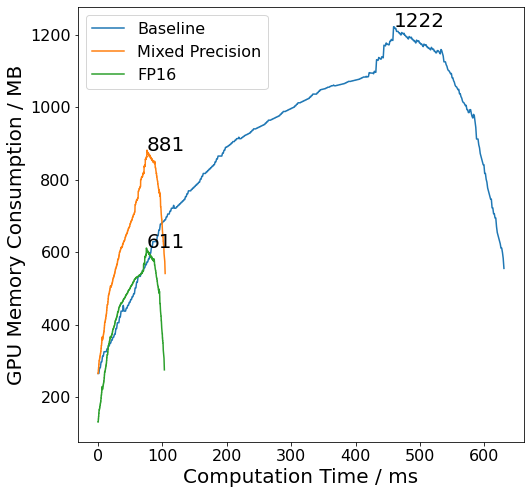

In [ ]:
exps = (
    'baseline_256',
    # 'sparse90_256',
    'mp_256',
    'fp16_256',
    # 'chklayer_256',
    # 'chkres_256',
    # 'baseline_64',
    # 'chkres_64',
    # 'chkres_mp_256',
    # 'chkres_fp16_256',
    # 'chkres_mp_64',
    # 'chkres_fp16_64',
)
mem_log_df, other_mems_df = get_dfs(exps, 'wrn')
plot_mem(mem_log_df, other_mems_df, labels=["Baseline", "Mixed Precision", "FP16"])

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

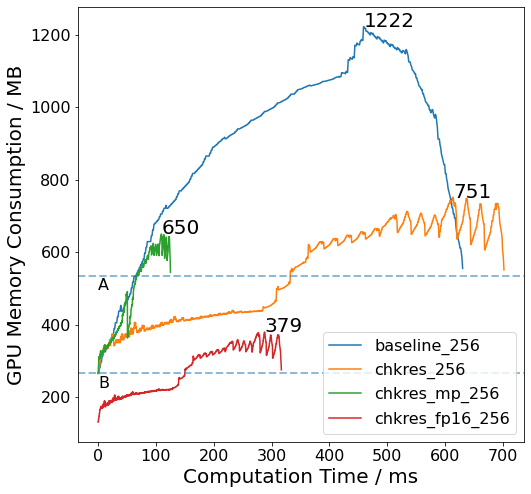

In [ ]:
exps = (
    'baseline_256',
    # 'sparse90_256',
    # 'mp_256',
    # 'fp16_256',
    # 'chklayer_256',
    'chkres_256',
    # 'baseline_64',
    # 'chkres_64',
    'chkres_mp_256',
    'chkres_fp16_256',
    # 'chkres_mp_64',
    # 'chkres_fp16_64',
)
mem_log_df, other_mems_df = get_dfs(exps, 'wrn')
hlines = [
          ('A', 561240064), # original checkpointing limit
          # ('C', 558106624), # MP checkpointing limit
          ('B', 278809600), # FP16 checkpointing limit
]
plot_mem(mem_log_df, other_mems_df, hlines=hlines)

In [ ]:
other_mems_df

,init,model,starttime,endtime,warmup,input,enter,zero,fwd,bwd,step,max
exp,,,,,,,,,,,,
baseline_256,0,277931520,1.610640e+09,1.610640e+09,842764288,842764288,842764288,560480256,1419512832,843788800,843788800,1737236480
chkres_256,0,278980096,1.610641e+09,1.610641e+09,835686400,835686400,835686400,558710784,739697664,836710912,836710912,1082718208
chkres_mp_256,0,278980096,1.610641e+09,1.610641e+09,838112256,838112256,838112256,559498240,661512704,838624768,838625280,1001103360
chkres_fp16_256,0,137937920,1.610643e+09,1.610643e+09,421968384,421968384,421968384,281609216,375969792,422480896,422480896,660599808


In [ ]:
843788800 - 560480256 + 277931520

561240064

In [ ]:
838624768 - 559498240 + 278980096

558106624

In [ ]:
422480896 - 281609216 + 137937920

278809600

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

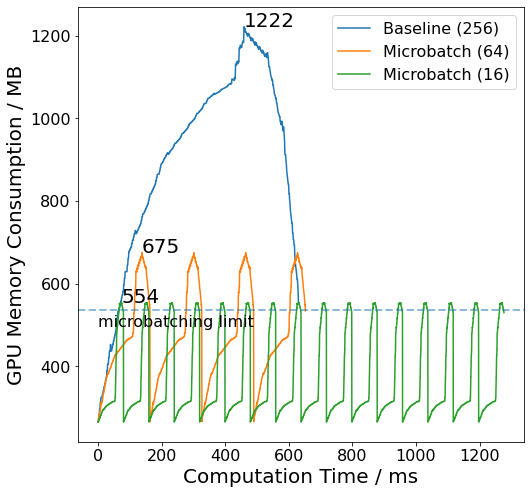

In [ ]:
exps = (
    'baseline_256',
    # 'sparse90_256',
    # 'mp_256',
    # 'fp16_256',
    # 'chklayer_256',
    # 'chkres_256',
    # 'baseline_64',
    'baseline_64_2',
    'baseline_16_2',
    # 'chkres_64',
    # 'chkres_mp_256',
    # 'chkres_fp16_256',
    # 'chkres_mp_64',
    # 'chkres_fp16_64',
)
mem_log_df, other_mems_df = get_dfs(exps, 'wrn')
plot_mem(mem_log_df, other_mems_df, labels=["Baseline (256)", "Microbatch (64)", "Microbatch (16)"], hlines=[('microbatching limit', 561240064)])

In [ ]:
other_mems_df

,init,model,starttime,endtime,warmup,input,enter,zero,fwd,bwd,step,max
exp,,,,,,,,,,,,
baseline_256,0,277931520,1.610640e+09,1.610640e+09,842764288,842764288,842764288,560480256,1419512832,843788800,843788800,1737236480
baseline_64_2,0,278980096,6.442563e+09,6.442563e+09,836012544,836012544,836012544,559757824,775966208,836269056,836269056,1050239488


In [ ]:
843788800 - 560480256 + 277931520

561240064

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

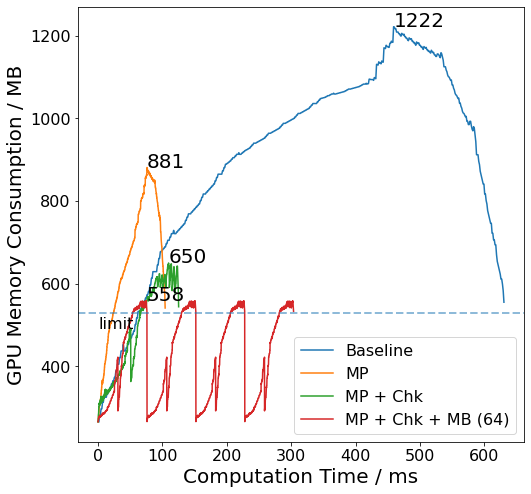

In [ ]:
exps = (
    'baseline_256',
    # 'sparse90_256',
    'mp_256',
    # 'fp16_256',
    # 'chklayer_256',
    # 'chkres_256',
    # 'baseline_64',
    # 'chkres_64',
    'chkres_mp_256',
    # 'chkres_fp16_256',
    'chkres_mp_64_2',
    # 'chkres_fp16_64',
)
mem_log_df, other_mems_df = get_dfs(exps, 'wrn')
plot_mem(mem_log_df, other_mems_df, labels=["Baseline", "MP", "MP + Chk", "MP + Chk + MB (64)"], hlines=[('limit', 556674048)])

In [ ]:
other_mems_df

,init,model,starttime,endtime,warmup,input,enter,zero,fwd,bwd,step,max
exp,,,,,,,,,,,,
baseline_256,0,277931520,1.610640e+09,1.610640e+09,842764288,842764288,842764288,560480256,1419512832,843788800,843788800,1737236480
mp_256,0,277931520,1.610641e+09,1.610641e+09,835294208,835294208,835294208,557859840,1132153344,835806720,835807232,1242234880
chkres_mp_256,0,278980096,1.610641e+09,1.610641e+09,838112256,838112256,838112256,559498240,661512704,838624768,838625280,1001103360
chkres_mp_64,0,278980096,1.610641e+09,1.610641e+09,833654272,833654272,833654272,556088832,584253440,833782784,833783296,874855936


In [ ]:
833782784 - 556088832 + 278980096

556674048

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

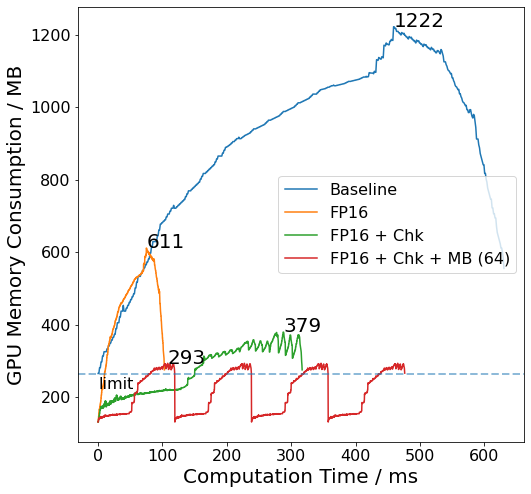

In [ ]:
exps = (
    'baseline_256',
    # 'sparse90_256',
    # 'mp_256',
    'fp16_256',
    # 'chklayer_256',
    # 'chkres_256',
    # 'baseline_64',
    # 'chkres_64',
    # 'chkres_mp_256',
    'chkres_fp16_256',
    # 'chkres_mp_64',
    'chkres_fp16_64_2',
)
mem_log_df, other_mems_df = get_dfs(exps, 'wrn')
plot_mem(mem_log_df, other_mems_df, labels=["Baseline", "FP16", "FP16 + Chk", "FP16 + Chk + MB (64)"], hlines=[('limit', 277114880)])

In [ ]:
other_mems_df

,init,model,starttime,endtime,warmup,input,enter,zero,fwd,bwd,step,max
exp,,,,,,,,,,,,
baseline_256,0,277931520,1.610640e+09,1.610640e+09,842764288,842764288,842764288,560480256,1419512832,843788800,843788800,1737236480
fp16_256,0,137937920,1.610641e+09,1.610641e+09,421444096,421444096,421444096,280658944,712081408,421563392,421563392,822107136
chkres_fp16_256,0,137937920,1.610643e+09,1.610643e+09,421968384,421968384,421968384,281609216,375969792,422480896,422480896,660599808
chkres_fp16_64,0,137937920,1.610643e+09,1.610643e+09,418952192,418952192,418952192,279903744,303887872,419080704,419080704,529142272


In [ ]:
419080704 - 279903744 + 137937920

277114880

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

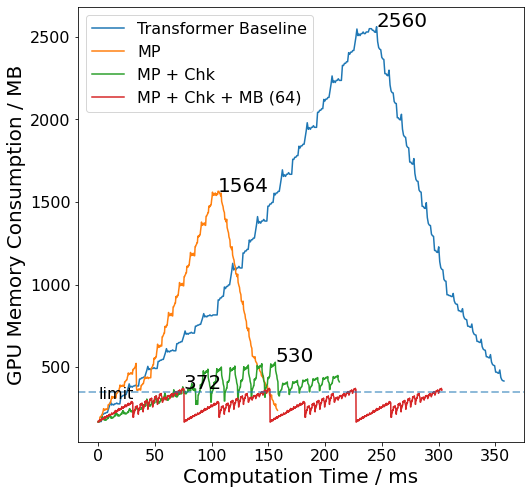

In [5]:
exps = (
    'baseline_256',
    'mp_256',
    # 'chk_256',
    'chk_mp_256',
    # 'baseline_64',
    # 'chk_64',
    'chk_mp_64_2',
)
mem_log_df, other_mems_df = get_dfs(exps, 'transformer')
plot_mem(mem_log_df, other_mems_df, labels=["Transformer Baseline", "MP", "MP + Chk", "MP + Chk + MB (64)"], hlines=[('limit', 367018496)])

In [ ]:
other_mems_df

,init,model,starttime,endtime,warmup,input,enter,zero,fwd,bwd,step,max
exp,,,,,,,,,,,,
baseline_256,555103744,734811648,1.610747e+09,1.610747e+09,1116248064,1116248064,1116248064,927102976,3399198720,1126734336,1126734336,3442316288
mp_256,1304871424,1485365760,1.610747e+09,1.610747e+09,1880696832,1880696832,1880696832,1678706688,3117291520,1710164480,1710164992,3146653184
chk_mp_256,555103744,731665920,1.610747e+09,1.610747e+09,1122016256,1122016256,1122016256,928152576,1040411648,1132502528,1132503040,1311633920
chk_mp_64,555103744,731665920,1.610747e+09,1.610747e+09,1102879744,1102879744,1102879744,915045376,946255872,1105501696,1105502208,1129278976


In [ ]:
1105501696 - 915045376 + 731665920 - 555103744

367018496

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

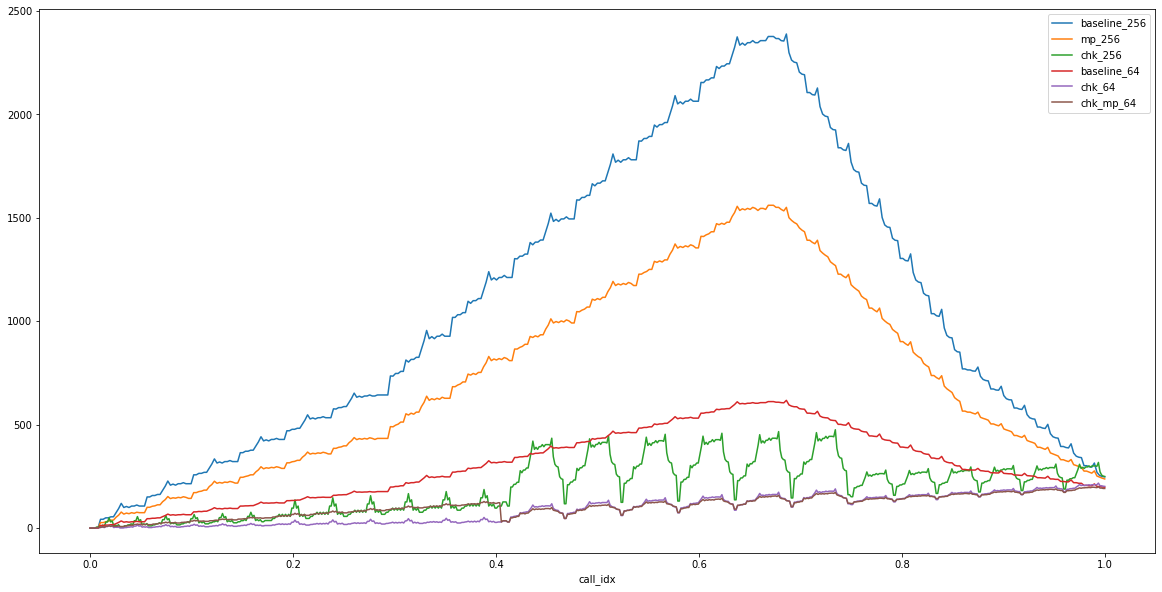

In [ ]:
plot_mem(mem_log_df_transformer)